# 1. Power Plants in Germany

This file covers german power plants. It downloads the power plant list from the German Federal Network Agency (BNetzA) and augments it with more information.

## Table of Contents
* [1. Power Plants in Germany](#1.-Power-Plants-in-Germany)
* [2. License](#2.-License)
* [3. Prepare the environment](#3.-Prepare-the-environment)
* [4. Specify the source URLs:](#4.-Specify-the-source-URLs:)
* [5. Define functions](#5.-Define-functions)
* [6. Downloads](#6.-Downloads)
	* [6.1 Download the BNetzA power plant list](#6.1-Download-the-BNetzA-power-plant-list)
	* [6.2 Download the Uba Plant list](#6.2-Download-the-Uba-Plant-list)
* [7. Translate contents](#7.-Translate-contents)
	* [7.1 Columns](#7.1-Columns)
	* [7.2 Fuel types](#7.2-Fuel-types)
	* [7.3 Power plant status](#7.3-Power-plant-status)
	* [7.4 CHP Capability](#7.4-CHP-Capability)
	* [7.5 EEG](#7.5-EEG)
	* [7.6 UBA Columns](#7.6-UBA-Columns)
* [8. Process data](#8.-Process-data)
	* [8.1 Set index to the BNetzA power plant ID](#8.1-Set-index-to-the-BNetzA-power-plant-ID)
	* [8.2 Merge data from UBA List](#8.2-Merge-data-from-UBA-List)
		* [8.2.1 case 1-1](#8.2.1-case-1-1)
		* [8.2.2 case n-1](#8.2.2-case-n-1)
		* [8.2.3 case 1-n](#8.2.3-case-1-n)
		* [8.2.4 Merge into plantlist](#8.2.4-Merge-into-plantlist)
	* [8.3 Delete fuels not in focus](#8.3-Delete-fuels-not-in-focus)
	* [8.4 Add Columns for shutdown and retrofit](#8.4-Add-Columns-for-shutdown-and-retrofit)
	* [8.5 Convert input colums to usable data types](#8.5-Convert-input-colums-to-usable-data-types)
	* [8.6 Identify generation technology](#8.6-Identify-generation-technology)
		* [8.6.1 Process technology information from UBA list](#8.6.1-Process-technology-information-from-UBA-list)
		* [8.6.2 Identify generation technology based on BNetzA information](#8.6.2-Identify-generation-technology-based-on-BNetzA-information)
	* [8.7 Add country code](#8.7-Add-country-code)
	* [8.8 Add efficiency data](#8.8-Add-efficiency-data)
		* [8.8.1 Efficiencies from research](#8.8.1-Efficiencies-from-research)
			* [8.8.1.1 Import data](#8.8.1.1-Import-data)
			* [8.8.1.2 Plot efficiencies by year of commissioning](#8.8.1.2-Plot-efficiencies-by-year-of-commissioning)
			* [8.8.1.3 Determine least-squares approximation based on researched data (planned)](#8.8.1.3-Determine-least-squares-approximation-based-on-researched-data-%28planned%29)
			* [8.8.1.4 Apply efficiency approximation from least squares approximation (planned)](#8.8.1.4-Apply-efficiency-approximation-from-least-squares-approximation-%28planned%29)
		* [8.8.2 Efficiencies from literature](#8.8.2-Efficiencies-from-literature)
			* [8.8.2.1 Import data](#8.8.2.1-Import-data)
			* [8.8.2.2 Apply efficiency approximation from literature](#8.8.2.2-Apply-efficiency-approximation-from-literature)
	* [8.9 Add geodata](#8.9-Add-geodata)
* [9. Define final output](#9.-Define-final-output)
	* [9.1 Verification](#9.1-Verification)
		* [9.1.1 Capacities by plant status](#9.1.1-Capacities-by-plant-status)
		* [9.1.2 Power plant age](#9.1.2-Power-plant-age)
		* [9.1.3 Block size vs year of commissioning](#9.1.3-Block-size-vs-year-of-commissioning)
	* [9.2 Logical checks](#9.2-Logical-checks)
		* [9.2.1 Every power plant needs a capacity](#9.2.1-Every-power-plant-needs-a-capacity)
		* [9.2.2 Commissioning Dates](#9.2.2-Commissioning-Dates)
		* [9.2.3 Compare UBA and BNetzA data](#9.2.3-Compare-UBA-and-BNetzA-data)
			* [9.2.3.1 Postcodes of BNetzA and UBA lists should match](#9.2.3.1-Postcodes-of-BNetzA-and-UBA-lists-should-match)
			* [9.2.3.2 Compare Installed capacities](#9.2.3.2-Compare-Installed-capacities)
			* [9.2.3.3 Compare Comissioning Years](#9.2.3.3-Compare-Comissioning-Years)
* [10. Documenting the data package (meta data)](#10.-Documenting-the-data-package-%28meta-data%29)
* [11. Write the results to file](#11.-Write-the-results-to-file)


# 2. License

FRAUKE: License nur im readme.md
- This notebook is published under the LICENSENAME

# 3. Prepare the environment

In [1]:
import urllib.request
import pandas as pd
import numpy as np
import posixpath
import urllib.parse
import datetime  
import os.path
import yaml  # http://pyyaml.org/, pip install pyyaml, conda install pyyaml
import json
import subprocess
import sqlite3
import logging

from bokeh.charts import Scatter, show
from bokeh.io import output_notebook

output_notebook()
%matplotlib inline 
# FRAUKE: Nutzt ihr matplotlib und bokeh? Falls ihr auf matplotlib
# verzichten könnt nehmt es lieber raus, das ist kompliziert zu installieren für den 
# Nutzer und gibt bei mir auch immer Warnungen aus
# Jan: Die imports sollten alle gruppiert am Anfang des Skriptes stehen.

# logger is set up
logger = logging.getLogger('notebook')
logger.setLevel('INFO')
nb_root_logger = logging.getLogger()
formatter = logging.Formatter(
    '%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    datefmt='%d %b %Y %H:%M:%S'
)
nb_root_logger.handlers[0].setFormatter(formatter)

# create download and output folders if they do not exist
os.makedirs('downloads', exist_ok=True)
os.makedirs('output', exist_ok=True)
os.makedirs(os.path.join('output',
                         'datapackage_powerplants_germany'),
            exist_ok=True)    
os.makedirs(os.path.join('output',
                         'datapackage_powerplants_germany',
                         'original_data'),
            exist_ok=True)
# JONATHAN: os.path.join verkettet die Argumente mit dem System-spezifischen
# path seperator, dann funktionieren die paths z.B. auch mit Linux
# FRAUKE: Eure Ordnerstruktur ist anders, ich hab mich gewundert, dass unter output
# original_data liegt. Sollte das nicht lieber in input sein?
# FRAUKE: Würde den Ordner inputs in input umbenennen (heißt ja auch output und nicht
# outputs und dann ist es wie bei unserem)

logger.info('Downloading file moin') 

Loading BokehJS ...

# 4. Specify the source URLs:

In [2]:
# Jan: So wird es übersichtlicher, allerdings ist es etwas über 80 chars:
# url_bnetza = ('http://www.bundesnetzagentur.de/SharedDocs/Downloads/DE/'
#               'Sachgebiete/Energie/Unternehmen_Institutionen/Versorgungssicherheit/'
#               'Erzeugungskapazitaeten/Kraftwerksliste/Kraftwerksliste_CSV.csv'
#               '?__blob=publicationFile&v=10')
# BNetzA Power plant list
url_bnetza = ('http://www.bundesnetzagentur.de/SharedDocs/Downloads/DE/'
              'Sachgebiete/Energie/Unternehmen_Institutionen/Versorgungssicherheit/'
              'Erzeugungskapazitaeten/Kraftwerksliste/Kraftwerksliste_CSV.csv'
              '?__blob=publicationFile&v=10')

# UBA Power plant list
# FRAUKE: Kann die alte url raus?
# url_uba = 'http://www.umweltbundesamt.de/sites/default/files/medien/376/dokume
# nte/kraftwerke_in_deutschland_ab_100_megawatt_elektrischer_leistung_2015_09.xls
url_uba = ('http://www.umweltbundesamt.de/sites/default/files/medien/376/'
           'dokumente/kraftwerke_in_deutschland_2016_kraftwerksdatenbank.xls')


# 5. Define functions

This section defines functions used multiple times within this script

In [3]:
def downloadandcache(url):
    """
    Download a file into a folder called "downloads".
    Returns the local filepath.
    
    Parameters
    ----------
    url : str
        Url of a file to be downloaded

    """
    
    path = urllib.parse.urlsplit(url).path
    filename = posixpath.basename(path)
    now = datetime.datetime.now()
    datestring = str(now.year) + "-" + str(now.month) + "-" + str(now.day)
    filepath = os.path.join('downloads', datestring + "-" + filename)
    filepath_original_data = os.path.join('output',
                                          'datapackage_powerplants_germany',
                                          'original_data',
                                          filename)
    
    #check if file exists, otherwise download it
    if not os.path.exists(filepath):
        logger.info('Downloading file %s', filename) 
        urllib.request.urlretrieve(url, filepath)
        urllib.request.urlretrieve(url, filepath_original_data)
    else:
        logger.info('Using local file from %s', filepath)
    #filepath = './'+filepath
    return filepath

# 6. Downloads

## 6.1 Download the BNetzA power plant list

This section downloads the BNetzA power plant list and converts it to a pandas data frame

In [4]:
bnetza_data_filepath = downloadandcache(url_bnetza)
plantlist = pd.read_csv(bnetza_data_filepath,
                        skiprows=9,
                        sep=';',  # CSV field separator, default is ','
                        thousands='.',  # Thousands separator, default is ','
                        decimal=',',  # Decimal separator, default is '.'  
                        encoding='cp1252')
plantlist.head()

,Kraftwerksnummer Bundesnetzagentur,Unternehmen,Kraftwerksname,PLZ (Standort Kraftwerk),Ort (Standort Kraftwerk),Straße und Hausnummer (Standort Kraftwerk),Bundesland,Blockname,Aufnahme der kommerziellen Stromerzeugung der derzeit in Betrieb befindlichen Erzeugungseinheit (Jahr),Kraftwerksstatus (in Betrieb/ vorläufig stillgelegt/ saisonale Konservierung Gesetzlich an Stilllegung gehindert/ Sonderfall),Energieträger,"Spezifizierung ""Mehrere Energieträger"" und ""Sonstige Energieträger"" - Hauptbrennstoff","Spezifizierung ""Mehrere Energieträger"" - Zusatz- / Ersatzbrennstoffe",Auswertung Energieträger (Zuordnung zu einem Hauptenergieträger bei Mehreren Energieträgern),Vergütungsfähig nach EEG (ja/nein),Wärmeauskopplung (KWK) (ja/nein),Netto-Nennleistung (elektrische Wirkleistung) in MW,Bezeichnung Verknüpfungspunkt (Schaltanlage) mit dem Stromnetz der Allgemeinen Versorgung gemäß Netzbetreiber,Netz- oder Umspannebene des Anschlusses in kV,Name Stromnetzbetreiber
0,BNA0001,NaN,NaN,52074,Aachen,NaN,Nordrhein-Westfalen,NaN,1997,in Betrieb,Windenergie (Onshore-Anlage),NaN,NaN,Windenergie (Onshore-Anlage),Ja,NaN,15.0,NaN,MS,INFRAWEST GmbH
1,BNA1011,Breeze Three Energy GmbH & Co. KG,Windpark Waldhausen,73433,Aalen,NaN,Baden-Württemberg,NaN,2006,in Betrieb,Windenergie (Onshore-Anlage),NaN,NaN,Windenergie (Onshore-Anlage),Ja,Nein,14.0,DE0010107343300000000000000287689 & DE 0010107...,20,Netzgesellschaft Ostwürttemberg DonauRies GmbH
2,BNA0002,ecoJoule construct GmbH,NaN,28832,Achim,NaN,Niedersachsen,NaN,2002,in Betrieb,Windenergie (Onshore-Anlage),NaN,NaN,Windenergie (Onshore-Anlage),Ja,NaN,13.3,NaN,HS/MS,EWE NETZ GmbH
3,BNA0003,Sendenhorster Windenergie GmbH & Co. KG,NaN,59229,Ahlen,NaN,Nordrhein-Westfalen,NaN,2003,in Betrieb,Windenergie (Onshore-Anlage),NaN,NaN,Windenergie (Onshore-Anlage),Ja,NaN,15.0,NaN,MS,Stadtwerke Ahlen Netz GmbH
4,BNA1099,Breloh Windenergie GmbH und Co. KG,11 Windkraftanlagen,59227,Ahlen,Halene - Kampen,Nordrhein-Westfalen,"11 Windkraftanlagen 2,3 MW",NaN,in Betrieb,Windenergie (Onshore-Anlage),NaN,NaN,Windenergie (Onshore-Anlage),Ja,NaN,25.3,"Umspannwerk Rosendahl, Ahlen",110,Westnetz GmbH


## 6.2 Download the Uba Plant list

This section downloads the power plant list from the German Federal Environment Agency (UBA) and converts it to a pandas data frame.

In [5]:
uba_data_filepath = downloadandcache(url_uba)
plantlist_uba = pd.read_excel(uba_data_filepath, skiprows=9)
plantlist_uba.head()

,Kraftwerksname / Standort,Betreiber,Bundesland,Standort-PLZ,Kraftwerksstandort,Elektrische Bruttoleistung (MW),Fernwärme-leistung (MW),Inbetriebnahme (ggf. Ertüchtigung),Anlagenart,Primärenergieträger
0,Ahrensfelde A bis D,Vattenfall Europe GmbH,BB,16356.0,Ahrensfelde,152.0,NaN,1990,GT,Erdgas
1,Albbruck-Dogern,Rheinkraftwerk Albbruck-Dogern AG,BW,79774.0,Albbruck,108.9,NaN,1933 / 2009,LWK,Wasser
2,"Altbach/Deizisau GT A-C, E",EnBW Kraftwerke AG,BW,73776.0,Altbach,305.0,NaN,1971-1997,GT,Erdgas
3,Altbach/Deizisau HKW 1,EnBW Kraftwerke AG,BW,73776.0,Altbach,476.0,280.0,1985 (2006),HKW,Steinkohle
4,Altbach/Deizisau HKW 2,EnBW Kraftwerke AG,BW,73776.0,Altbach,379.0,280.0,1997 (2012),HKW (DT),Steinkohle


# 7. Translate contents

## 7.1 Columns

A dictionary with the original column names to the new column names is created. This dictionary is used to translate the column names.

In [6]:
# JONATHAN so könnte man die 80 Zeichen Zeilenlänge einhalten:
# FRAUKE: Ich würde die Übersetzungen in eine Übersetzungs-csv auslagern,
# dann hat mein ein Dokument in dem man sowas ändern kann
# ausführlicher beschrieben hab ich das hier: https://www.dropbox.com/home/Datenplattform/Daten/Skripte?preview=Peer-Review.docx
dict_columns = {
    'Kraftwerksnummer Bundesnetzagentur':
        'id',
    'Unternehmen':
        'company',
    'Kraftwerksname':
        'name',
    'PLZ\n(Standort Kraftwerk)':
        'postcode',
    'Ort\n(Standort Kraftwerk)':
        'city',
    'Straße und Hausnummer (Standort Kraftwerk)':
        'street',
    'Bundesland':
        'state',
    'Blockname':
        'block',
    ('Aufnahme der kommerziellen Stromerzeugung der derzeit in Betrieb '
     'befindlichen Erzeugungseinheit\n(Jahr)'):
        'commissioned',
    ('Kraftwerksstatus \n(in Betrieb/\nvorläufig stillgelegt/\nsaisonale '
     'Konservierung\nReservekraftwerk/\nSonderfall)'):
        'status',
    ('Kraftwerksstatus \n(in Betrieb/\nvorläufig stillgelegt/\nsaisonale '
     'Konservierung\nGesetzlich an Stilllegung gehindert/\nSonderfall)'):
        'status',    
    'Energieträger':
        'fuel_basis',
    ('Spezifizierung "Mehrere Energieträger" und "Sonstige Energieträger" - '
     'Hauptbrennstoff'): 'fuel_multiple1',
    'Spezifizierung "Mehrere Energieträger" - Zusatz- / Ersatzbrennstoffe':
        'fuel_multiple2',
    ('Auswertung\nEnergieträger (Zuordnung zu einem Hauptenergieträger bei '
     'Mehreren Energieträgern)'):
        'fuel',
    'Vergütungsfähig nach EEG\n(ja/nein)':
        'eeg',
    'Wärmeauskopplung (KWK)\n(ja/nein)':
        'chp',
    'Netto-Nennleistung (elektrische Wirkleistung) in MW':
        'capacity',
    ('Bezeichnung Verknüpfungspunkt (Schaltanlage) mit dem Stromnetz der '
     'Allgemeinen Versorgung gemäß Netzbetreiber'):
        'network_node',
    'Netz- oder Umspannebene des Anschlusses in kV':
        'voltage',
    'Name Stromnetzbetreiber':
        'network_operator',
    'Kraftwerksname / Standort':
        'uba_name',
    'Betreiber ':
        'uba_company',
    'Standort-PLZ':
        'uba_postcode',
    'Kraftwerksstandort':
        'uba_city',
    'Elektrische Bruttoleistung (MW)':
        'uba_capacity',
    'Fernwärme-leistung (MW)':
        'uba_chp_capacity',
    'Inbetriebnahme  (ggf. Ertüchtigung)':
        'uba_commissioned',
    'Anlagenart':
        'uba_technology',
    'Primärenergieträger':
        'uba_fuel',
}
plantlist.rename(columns=dict_columns, inplace=True)

# Check if all columns have been translated
for columnnames in plantlist.columns:
    # if columnnames not in dict_columns.values():
    if columnnames not in dict_columns.values():
        logger.error("Untranslated column: "+ columnnames)

## 7.2 Fuel types

In [7]:
dict_fuels = {
    'Steinkohle': 'coal',
    'Erdgas': 'natural_gas',
    'Braunkohle': 'lignite',
    'Kernenergie': 'uranium',
    'Pumpspeicher': 'pumped_storage',
    'Biomasse': 'biomass',
    'Mineralölprodukte': 'oil',
    'Laufwasser': 'hydro',
    'Sonstige Energieträger\n(nicht erneuerbar) ': 'other_non_renewable',
    'Abfall': 'waste',
    'Speicherwasser (ohne Pumpspeicher)': 'reservoir',
    'Unbekannter Energieträger\n(nicht erneuerbar)': 'unknown_non_renewable',
    'Mehrere Energieträger\n(nicht erneuerbar)': 'multiple_non_renewable',
    'Deponiegas': 'gas_landfill',
    'Windenergie (Onshore-Anlage)': 'wind_onshore',
    'Windenergie (Offshore-Anlage)': 'wind_offshore',
    'Solare Strahlungsenergie': 'solar',
    'Klärgas': 'gas_sewage',
    'Geothermie': 'geothermal',
    'Grubengas': 'gas_mine'
}
plantlist["fuel"].replace(dict_fuels, inplace=True)
# JONATHAN Dieser Befehl an dieser Stelle erscheint mir überflüssig,
# ebenso in den folgenden Zellen
plantlist["fuel"].unique()

# Check if all fuels have been translated
for fuelnames in plantlist["fuel"].unique():
    if fuelnames not in dict_fuels.values():
        logger.error("Untranslated fuel: " + fuelnames)

## 7.3 Power plant status

In [8]:
# FRAUKE: Auch hier: dictionary als csv-Datei value_translation_list.csv
dict_plantstatus = {
    'in Betrieb': 'operating',
    'In Betrieb': 'operating',
    'vorläufig stillgelegt': 'shutdown_temporary',
    'Vorläufig stillgelegt': 'shutdown_temporary',
    'Vorläufig Stillgelegt': 'shutdown_temporary',    
    'Sonderfall': 'special_case',
    'saisonale Konservierung': 'seasonal_conservation',
    'Saisonale Konservierung': 'seasonal_conservation',    
    'Reservekraftwerk':'reserve',
    'Endgültig Stillgelegt 2011': 'shutdown_2011',
    'Endgültig Stillgelegt 2012': 'shutdown_2012',
    'Endgültig Stillgelegt 2013': 'shutdown_2013',
    'Endgültig Stillgelegt 2014': 'shutdown_2014',
    'Endgültig Stillgelegt 2015': 'shutdown_2015',
    'Endgültig stillgelegt 2015': 'shutdown_2015',
    'Endgültig Stillgelegt 2016': 'shutdown_2016',
    'Gesetzlich an Stilllegung gehindert': 'operating',    
}  
plantlist['status'].replace(dict_plantstatus, inplace=True) 
plantlist['status'].unique()

# Check if all fuels have been translated
for statusnames in plantlist['status'].unique():
    if statusnames not in dict_plantstatus.values():
        logger.error('Untranslated plant status: '+ statusnames)

## 7.4 CHP Capability

In [9]:
dict_yesno ={
    'Nein': 'no',
    'nein': 'no',
    'Ja': 'yes',
    'ja': 'yes',    
}
plantlist['chp'].replace(dict_yesno, inplace=True)
plantlist['chp'].unique()

# Check if all fuels have been translated
for chpnames in plantlist['chp'].unique():
    if (chpnames not in dict_yesno.values()) & (str(chpnames) != 'nan'):
        logger.error('Untranslated chp capability: ' + str(chpnames))

## 7.5 EEG

In [10]:
plantlist['eeg'].replace(dict_yesno, inplace=True)
plantlist['eeg'].unique()

# Check if all fuels have been translated
for eegnames in plantlist['eeg'].unique():
    if (eegnames not in dict_yesno.values()) & (str(eegnames) != 'nan'):
        logger.error('Untranslated EEG type: ' + str(eegnames))

## 7.6 UBA Columns

Using the same dictionary as above

In [11]:
# JONATHAN: Wo wird hier (wie im MArkup angekündigt) das selbe dictionary verwendet?
# FRAUKE: Auch hier, ist übersichtlicher wenn das auch in der gleichen translation-csv
# hinterlegt ist
dict_uba_columns = {
    'Kraftwerksname / Standort': 'uba_name',
    'Betreiber ': 'uba_company',
    'Standort-PLZ': 'uba_postcode',
    'Kraftwerksstandort': 'uba_city',
    'Elektrische Bruttoleistung (MW)': 'uba_capacity',
    'Fernwärme-leistung (MW)': 'uba_chp_capacity',
    'Inbetriebnahme  (ggf. Ertüchtigung)': 'uba_commissioned',
    'Anlagenart': 'uba_technology',
    'Primärenergieträger': 'uba_fuel',
    'Bundesland':'uba_state',
}
plantlist_uba.rename(columns=dict_uba_columns, inplace=True)

# Check if all columns have been translated
for columnnames in plantlist_uba.columns:
    if columnnames not in dict_uba_columns.values():
        logger.error('Untranslated column: ' + columnnames)
        
# Prepare for matching
plantlist_uba['uba_id_string'] = (plantlist_uba['uba_name'] 
                                  + '_' 
                                  + plantlist_uba['uba_fuel'])

# 8. Process data

## 8.1 Set index to the BNetzA power plant ID

In [12]:
# Set Index of BNetzA power plant list to Kraftwerksnummer_Bundesnetzagentur
plantlist['bnetza_id'] = plantlist['id']
plantlist = plantlist.set_index('id')
plantlist.head() 

,company,name,postcode,city,street,state,block,commissioned,status,fuel_basis,fuel_multiple1,fuel_multiple2,fuel,eeg,chp,capacity,network_node,voltage,network_operator,bnetza_id
id,,,,,,,,,,,,,,,,,,,,
BNA0001,NaN,NaN,52074,Aachen,NaN,Nordrhein-Westfalen,NaN,1997,operating,Windenergie (Onshore-Anlage),NaN,NaN,wind_onshore,yes,NaN,15.0,NaN,MS,INFRAWEST GmbH,BNA0001
BNA1011,Breeze Three Energy GmbH & Co. KG,Windpark Waldhausen,73433,Aalen,NaN,Baden-Württemberg,NaN,2006,operating,Windenergie (Onshore-Anlage),NaN,NaN,wind_onshore,yes,no,14.0,DE0010107343300000000000000287689 & DE 0010107...,20,Netzgesellschaft Ostwürttemberg DonauRies GmbH,BNA1011
BNA0002,ecoJoule construct GmbH,NaN,28832,Achim,NaN,Niedersachsen,NaN,2002,operating,Windenergie (Onshore-Anlage),NaN,NaN,wind_onshore,yes,NaN,13.3,NaN,HS/MS,EWE NETZ GmbH,BNA0002
BNA0003,Sendenhorster Windenergie GmbH & Co. KG,NaN,59229,Ahlen,NaN,Nordrhein-Westfalen,NaN,2003,operating,Windenergie (Onshore-Anlage),NaN,NaN,wind_onshore,yes,NaN,15.0,NaN,MS,Stadtwerke Ahlen Netz GmbH,BNA0003
BNA1099,Breloh Windenergie GmbH und Co. KG,11 Windkraftanlagen,59227,Ahlen,Halene - Kampen,Nordrhein-Westfalen,"11 Windkraftanlagen 2,3 MW",NaN,operating,Windenergie (Onshore-Anlage),NaN,NaN,wind_onshore,yes,NaN,25.3,"Umspannwerk Rosendahl, Ahlen",110,Westnetz GmbH,BNA1099


## 8.2 Merge data from UBA List

In [13]:
# JONATHAN: Diese CSV Datei erstellt ihr selber, oder? Dann sollte sie im 
# datapackage-konformen standardformat erstellt werden, = so, dass die unten
# benannten default Parameter beim Einlesen zutreffend sind.
# Wichtiger noch: Wwo kommt die Matchingliste her? Habt ihr die selber ertellt?
# Wenn ja: nach welcher Methode?
# FRAUKE: Könnte das Erstellen des Matching auch Teil des Skriptes sein? Oder als Extra-
# Skript mit zur Verfügung gestellt werden? Oder eben wie Jonathan schrieb mind. ne
# Erklärung wäre gut wie die Liste erstellt wurde

# UBA List import here # JONATHAN: Diesen Kommentar verstehe ich nicht
matchinglist=pd.read_csv(
    'inputs/matching_bnetza_uba.csv', 
    skiprows=0,
    sep=';',  # CSV field separator, default is ','
    thousands='.',  # Thousands separator, default is ','
    decimal=',',  # Decimal separator, default is '.')  
    encoding='cp1252')
matchinglist['uba_id_string'] = (matchinglist['uba_match_name'] 
                                 + '_' 
                                 + matchinglist['uba_match_fuel'])
matchinglist.head()

,ID BNetzA,uba_match_name,uba_match_fuel,uba_id_string
0,BNA0005,Ahrensfelde A bis D,Erdgas,Ahrensfelde A bis D_Erdgas
1,BNA0006,Ahrensfelde A bis D,Erdgas,Ahrensfelde A bis D_Erdgas
2,BNA0007,Ahrensfelde A bis D,Erdgas,Ahrensfelde A bis D_Erdgas
3,BNA0008,Ahrensfelde A bis D,Erdgas,Ahrensfelde A bis D_Erdgas
4,BNA0010a,Albbruck-Dogern,Wasser,Albbruck-Dogern_Wasser


### 8.2.1 case 1-1

In [14]:
# Check for cases:
# 1-1 One BNetzA ID to one UBA-ID

match1t1 = matchinglist[
    (matchinglist.duplicated(subset=['uba_id_string'], keep=False) == False) 
    & (matchinglist.duplicated(subset=['ID BNetzA'], keep=False) == False)]
match1t1 = pd.merge(match1t1, plantlist_uba,
                    left_on='uba_id_string', 
                    right_on='uba_id_string',
                    how='left')
match1t1 = match1t1.set_index('ID BNetzA')
# match1t1.head() # JONATHAN Dieser Befehl an dieser Stelle erscheint mir überflüssig

#Add comment
match1t1['merge_comment'] = ('List matching type: Single UBA power plant '
                             'assigned to single BNetzA power plant')

### 8.2.2 case n-1

In [15]:
# JONATHAN: Diese und die folgende Zelle sehen sehr ähnlich aus. Könnte Teile 
# des reduntanten Codes evtl. in eine/mehrere Funktionen auslagern und mehrfach 
# audrufen, wie von Stefan angeregt?

# Match multiple BNetza IDs to one UBA ID #JONATHAN: Dieser Kommentar besser in Markup-Zelle?
# Matching structure (example): 
# bnetza_id uba_id
# 1         1
# 2         1
# 3         1
# 4         2
# 5         2

# Get relevant entries from the matchinglist and merge the corresponding 
# UBA Data to the list.
matchnt1= matchinglist[
    (matchinglist.duplicated(subset=['uba_id_string'], keep=False) == True)
    & (matchinglist.duplicated(subset=['ID BNetzA'], keep=False)== False)]
matchnt1 = pd.merge(matchnt1, plantlist_uba,
                    left_on='uba_id_string', right_on='uba_id_string', how='left')
matchnt1 = matchnt1.set_index('ID BNetzA')

# Import BNetzA Capacities and CHP criterion into matchnt1 dataframe
plantlist_capacities = pd.DataFrame(plantlist[['capacity', 'chp']]).rename(
    columns={'capacity': 'capacity_bnetza', 'chp': 'chp_bnetza'})
matchnt1 = pd.merge(matchnt1, plantlist_capacities,
                    left_index=True, right_index=True, how='left')

# Get sum of BNetzA Capacitites for each UBA Index and merge into matchnt1 dataframe
plantlist_uba_capacitysum = pd.DataFrame(
    matchnt1.groupby('uba_id_string').sum()['capacity_bnetza']).rename(
        columns={'capacity_bnetza': 'capacity_bnetza_aggregate'})
matchnt1 = pd.merge(matchnt1, plantlist_uba_capacitysum,
                    left_on='uba_id_string', right_index=True, how='left')

# Scale UBA Capacities based BNetzA Data
matchnt1['uba_capacity_scaled'] = (matchnt1['uba_capacity']
                                   * matchnt1['capacity_bnetza']
                                   / matchnt1['capacity_bnetza_aggregate'])

# determine sum of capacities with chp capability and add to matchnt1
plantlist_uba_chp_capacities = matchnt1[(matchnt1['chp_bnetza'] == 'yes')]
plantlist_uba_chp_capacitysum = pd.DataFrame(
    plantlist_uba_chp_capacities.groupby('uba_id_string')
    .sum()['capacity_bnetza']) 
plantlist_uba_chp_capacitysum = plantlist_uba_chp_capacitysum.rename(
    columns={'capacity_bnetza': 'capacity_bnetza_with_chp'})
matchnt1 = pd.merge(matchnt1, plantlist_uba_chp_capacitysum,
                    left_index=True, right_index=True, how='left')

matchnt1['uba_chp_capacity_scaled'] = (matchnt1['uba_chp_capacity']
                                       * matchnt1['capacity_bnetza']
                                       / matchnt1['capacity_bnetza_with_chp'])

# Change column names for merge later on
matchnt1['uba_chp_capacity_original'] = matchnt1['uba_chp_capacity']
matchnt1['uba_chp_capacity'] = matchnt1['uba_chp_capacity_scaled']
matchnt1['uba_capacity_original'] = matchnt1['uba_capacity']
matchnt1['uba_capacity'] = matchnt1['uba_capacity_scaled']

#Add comment
matchnt1['merge_comment'] = ('List matching type: UBA capacity distributed '
                             'proportionally to multiple BNetzA power plants')

# FRAUKE: Kann der Kommentar hier weg?
# Drop columns not needed anymore
#colsToDrop = ['capacity_bnetza', 'chp_bnetza','capacity_bnetza_with_chp', 'capacity_bnetza_aggregate', 'uba_chp_capacity_scaled', 'uba_capacity_scaled']
#matchnt1 = matchnt1.drop(colsToDrop, axis=1)
matchnt1.head()

,uba_match_name,uba_match_fuel,uba_id_string,uba_name,uba_company,uba_state,uba_postcode,uba_city,uba_capacity,uba_chp_capacity,...,uba_fuel,capacity_bnetza,chp_bnetza,capacity_bnetza_aggregate,uba_capacity_scaled,capacity_bnetza_with_chp,uba_chp_capacity_scaled,uba_chp_capacity_original,uba_capacity_original,merge_comment
BNA0005,Ahrensfelde A bis D,Erdgas,Ahrensfelde A bis D_Erdgas,Ahrensfelde A bis D,Vattenfall Europe GmbH,BB,16356.0,Ahrensfelde,38.000000,NaN,...,Erdgas,37.5,no,150.0,38.000000,NaN,NaN,NaN,152.0,List matching type: UBA capacity distributed p...
BNA0006,Ahrensfelde A bis D,Erdgas,Ahrensfelde A bis D_Erdgas,Ahrensfelde A bis D,Vattenfall Europe GmbH,BB,16356.0,Ahrensfelde,38.000000,NaN,...,Erdgas,37.5,no,150.0,38.000000,NaN,NaN,NaN,152.0,List matching type: UBA capacity distributed p...
BNA0007,Ahrensfelde A bis D,Erdgas,Ahrensfelde A bis D_Erdgas,Ahrensfelde A bis D,Vattenfall Europe GmbH,BB,16356.0,Ahrensfelde,38.000000,NaN,...,Erdgas,37.5,no,150.0,38.000000,NaN,NaN,NaN,152.0,List matching type: UBA capacity distributed p...
BNA0008,Ahrensfelde A bis D,Erdgas,Ahrensfelde A bis D_Erdgas,Ahrensfelde A bis D,Vattenfall Europe GmbH,BB,16356.0,Ahrensfelde,38.000000,NaN,...,Erdgas,37.5,no,150.0,38.000000,NaN,NaN,NaN,152.0,List matching type: UBA capacity distributed p...
BNA0010a,Albbruck-Dogern,Wasser,Albbruck-Dogern_Wasser,Albbruck-Dogern,Rheinkraftwerk Albbruck-Dogern AG,BW,79774.0,Albbruck,83.647826,NaN,...,Wasser,79.5,no,103.5,83.647826,NaN,NaN,NaN,108.9,List matching type: UBA capacity distributed p...


### 8.2.3 case 1-n

In [16]:
# 1-n Case here #JONATHAN: Auch dieser Kommentar besser in Markup-Zelle?
# The resulting DataFrame should be called "match1tn"
# Matching structure: 
# bnetza_id uba_id
# 1         1
# 1         2
# 1         3
# 2         4
# 2         5

# Get relevant entries from the matchinglist and merge the corresponding UBA Data to the list.
match1tn= matchinglist[
    (matchinglist.duplicated(subset=['ID BNetzA'], keep=False) == True) & 
    (matchinglist.duplicated(subset=['uba_id_string'], keep=False)== False)]
match1tn = pd.merge(match1tn, plantlist_uba,
                    left_on='uba_id_string', right_on='uba_id_string', how='left')
match1tn = match1tn.set_index('ID BNetzA')
match1tn.head()

# Import BNetzA Capacities and CHP criterion into match1tn dataframe
plantlist_capacities = pd.DataFrame(plantlist[['capacity','chp']]).rename(
    columns = {'capacity': 'capacity_bnetza', 'chp': 'chp_bnetza'})
match1tn = pd.merge(match1tn, plantlist_capacities,
                    left_index=True, right_index=True, how='left')
match1tn.index.names=['ID BNetzA']
match1tn.head()

# Get sum of UBA Capacitites per BNetzA Index and merge to match1tn dataframe
plantlist_bnetza_capacitysum = pd.DataFrame(
    match1tn.groupby(match1tn.index).sum()['uba_capacity'])
plantlist_bnetza_capacitysum = plantlist_bnetza_capacitysum.rename(
    columns={'uba_capacity':'uba_capacity_aggregate'})
match1tn = pd.merge(match1tn, plantlist_bnetza_capacitysum,
                    left_index=True, right_index=True, how='left')

# Get sum of UBA CHP Capacities per BNetzA Index and merge to match1tn dataframe
plantlist_bnetza_chp_capacitysum = pd.DataFrame(
    match1tn.groupby(match1tn.index).sum()['uba_chp_capacity'])
plantlist_bnetza_chp_capacitysum = plantlist_bnetza_chp_capacitysum.rename(
    columns={'uba_chp_capacity': 'uba_chp_capacity_aggregate'})
match1tn = pd.merge(match1tn, plantlist_bnetza_chp_capacitysum,
                    left_index=True, right_index=True, how='left')

# Get UBA Technology for each BNetzA Index and merge into match1tn dataframe 
## Option 1: Take all technologies and merge them
#match1tn['uba_technology_aggregate'] = pd.DataFrame(
#    match1tn.groupby(match1tn.index)
#    .transform(lambda x: ', '.join(x))['uba_technology'])
## Option 2 (currently preferred): Take technology with highest occurence
match1tn['uba_technology_aggregate'] = pd.DataFrame(
    match1tn.groupby(match1tn.index)['uba_technology']
    .agg(lambda x: x.value_counts().index[0]))

# Get UBA Plant name
match1tn['uba_name_aggregate'] = pd.DataFrame(
    match1tn.groupby(match1tn.index).transform(lambda x: ', '.join(x))['uba_name'])

# Get UBA company name
match1tn['uba_company_aggregate'] = pd.DataFrame(
    match1tn.groupby(match1tn.index)['uba_company']
    .agg(lambda x:x.value_counts().index[0]))

# Change column names for merge later on
match1tn = match1tn.rename(
    columns={'uba_chp_capacity': 'uba_chp_capacity_original',
             'uba_capacity': 'uba_capacity_original',
             'uba_chp_capacity_aggregate': 'uba_chp_capacity',
             'uba_capacity_aggregate': 'uba_capacity'})
# match1tn['uba_chp_capacity_original'] = match1tn['uba_chp_capacity_aggregate']
# match1tn['uba_capacity_original'] = match1tn['uba_capacity_aggregate']

#Add comment
match1tn['merge_comment'] = ('List matching type: Multiple UBA capacities '
                             'aggregated to single BNetzA power plant')

# Drop columns not needed anymore
# colsToDrop = ['capacity_bnetza', 'chp_bnetza']
# match1tn = match1tn.drop(colsToDrop, axis=1)

# Drop duplicate rows and keep first entry
match1tn = match1tn.reset_index().drop_duplicates(subset='ID BNetzA',keep='first').set_index('ID BNetzA')

match1tn.head()

,uba_match_name,uba_match_fuel,uba_id_string,uba_name,uba_company,uba_state,uba_postcode,uba_city,uba_capacity_original,uba_chp_capacity_original,...,uba_technology,uba_fuel,capacity_bnetza,chp_bnetza,uba_capacity,uba_chp_capacity,uba_technology_aggregate,uba_name_aggregate,uba_company_aggregate,merge_comment
ID BNetzA,,,,,,,,,,,,,,,,,,,,,
BNA0073,Berlin-Mitte HKW GT 1,Erdgas,Berlin-Mitte HKW GT 1_Erdgas,Berlin-Mitte HKW GT 1,Vattenfall Europe GmbH,BE,10179.0,Berlin,178.0,1210.0,...,HKW / GuD,Erdgas,444.0,yes,468.0,1210.0,HKW / GuD,"Berlin-Mitte HKW GT 1, Berlin-Mitte HKW GT 2, ...",Vattenfall Europe GmbH,List matching type: Multiple UBA capacities ag...
BNA0606,Emsland D (Lingen) DT,Erdgas,Emsland D (Lingen) DT_Erdgas,Emsland D (Lingen) DT,RWE Power AG,NI,49808.0,Lingen,326.0,50.0,...,GuD,Erdgas,887.0,yes,888.0,50.0,GuD,"Emsland D (Lingen) DT, Emsland D (Lingen) GT 1...",RWE Power AG,List matching type: Multiple UBA capacities ag...
BNA1019,Wehr 1,Wasser,Wehr 1_Wasser,Wehr 1,Schluchseewerk AG,BW,79664.0,Wehr,248.0,NaN,...,PSW,Wasser,910.0,no,992.0,NaN,PSW,"Wehr 1, Wehr 2, Wehr 3, Wehr 4",Schluchseewerk AG,List matching type: Multiple UBA capacities ag...


### 8.2.4 Merge into plantlist

In [17]:
# Merge the UBA DataFrames
# Merge first two dataframes
plantlist_uba_for_merge = match1t1.append(matchnt1)

# Add third dataframe
plantlist_uba_for_merge = plantlist_uba_for_merge.append(match1tn)

# Merge plantlist_uba_for_merge into the plantlist
plantlist = pd.merge(plantlist, plantlist_uba_for_merge,
                     left_index=True, right_index=True, how='left')

In [18]:
plantlist.loc[['BNA0073']] #JONATHAN: Warum ist das hier?

,company,name,postcode,city,street,state,block,commissioned,status,fuel_basis,...,uba_fuel,uba_id_string,uba_match_fuel,uba_match_name,uba_name,uba_name_aggregate,uba_postcode,uba_state,uba_technology,uba_technology_aggregate
BNA0073,Vattenfall Europe Wärme AG,Mitte,10179,Berlin,Köpenicker Straße 60,Berlin,GuD Mitte,1996,operating,Erdgas,...,Erdgas,Berlin-Mitte HKW GT 1_Erdgas,Erdgas,Berlin-Mitte HKW GT 1,Berlin-Mitte HKW GT 1,"Berlin-Mitte HKW GT 1, Berlin-Mitte HKW GT 2, ...",10179.0,BE,HKW / GuD,HKW / GuD


## 8.3 Delete fuels not in focus

In [19]:
# FRAUKE: Erklärung, dass die in der renewable Liste drin sind.
# Delete unwanted fuels
plantlist = plantlist[(plantlist['fuel'] != 'solar')  #JONATHAN: Referenzierung der Spalten  mit ['spaltenname'] wie im Rest des Skriptes zwecks Einheitlichkeit
                       & (plantlist['fuel'] != 'wind_onshore') 
                       & (plantlist['fuel'] != 'wind_offshore')]

# FRAUKE: Hier wäre auch eine Erklärung gut, dass das die aufsummierten Kleinanlagen sind
# FRAUKE: Kommen die bei Euch tatsächlich ganz raus?
# Delete placeholder values
plantlist = plantlist[(plantlist['company'] != 'EEG-Anlagen < 10 MW') 
                       & (plantlist['company'] != 'Nicht-EEG-Anlagen < 10 MW')]

## 8.4 Add Columns for shutdown and retrofit

In [20]:
# JONATHAN: # Ich höre hier auf, die Zeilenlängen anzupassen, das solltet ihr aber noch machen
# Noch Eine Erklärung (im Markup), was hier passiert wäre gut, z.B.
# Extract the year when plants were shutdown or retrofit, using regular expressions
# FRAUKE: Zustimmung zu Jonathan. Wählt ihr commissioned und shutdown date aus UBA und
# BNetzA Liste aus wenn sie unterschiedlich sind oder wie geht ihr da vor?

# FRAUKE: Da kommt ne Warnmeldung: "A value is trying to be set on a copy of a slice
## from a DataFrame" Solche Ausdrücke: 'plantlist['uba_commissioned_1'][plantlist['retrofit']...
## besser mit .loc ansprechen

# Add columns with empty data
plantlist['shutdown'] = 'NaN'

plantlist['shutdown'] = pd.to_numeric(
    plantlist['status'].str.extract('[\w].+(\d\d\d\d)'), 
    errors='coerce')
plantlist['status'][plantlist['shutdown'] > 0] = 'shutdown'

# Fill retrofit data column
# Identify restrofit dates in UBA list
plantlist['retrofit'] = pd.to_numeric(
    plantlist['uba_commissioned'].str.extract('[(.+](\d\d\d\d)'), 
    errors='coerce')

# Split multiple commissioning dates as listed in UBA
plantlist['uba_commissioned_1'] = pd.to_numeric(
    plantlist['uba_commissioned'].str.extract('(\d\d\d\d)'), 
    errors='coerce')
plantlist['uba_commissioned_1'][plantlist['uba_commissioned_1'].isnull()] = pd.to_numeric(
    plantlist['uba_commissioned'].str.extract('(\d\d\d\d).+[\w]'), 
    errors='coerce')
plantlist['uba_commissioned_2'] = pd.to_numeric(
    plantlist['uba_commissioned'].str.extract('[\w].+(\d\d\d\d).+[\w]'),
    errors='coerce')
plantlist['uba_commissioned_3'] = pd.to_numeric(
    plantlist['uba_commissioned'].str.extract('[\w].+(\d\d\d\d)'),
    errors='coerce')

plantlist['uba_commissioned_1'][plantlist['retrofit'] == plantlist['uba_commissioned_1']] = ''
plantlist['uba_commissioned_2'][plantlist['retrofit'] == plantlist['uba_commissioned_2']] = ''
plantlist['uba_commissioned_3'][plantlist['retrofit'] == plantlist['uba_commissioned_3']] = ''

# Split multiple commissioning dates as listed in BNetzA
plantlist['commissioned_1'] = pd.to_numeric(
    plantlist['commissioned'].str.extract('(\d\d\d\d)'), 
    errors='coerce')
plantlist['commissioned_1'][plantlist['commissioned_1'].isnull()] = pd.to_numeric(
    plantlist['commissioned'].str.extract('(\d\d\d\d).+[\w]'),
    errors='coerce')
plantlist['commissioned_2'] = pd.to_numeric(
    plantlist['commissioned'].str.extract('[\w].+(\d\d\d\d).+[\w]'),
    errors='coerce')
plantlist['commissioned_3'] = pd.to_numeric(
    plantlist['commissioned'].str.extract('[\w].+(\d\d\d\d)'),
    errors='coerce')

# Show plantlist
plantlist[plantlist['status'] == 'shutdown']


C:\Users\Mario\Anaconda3\lib\site-packages\ipykernel\__main__.py:15: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
C:\Users\Mario\Anaconda3\lib\site-packages\ipykernel\__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Mario\Anaconda3\lib\site-packages\ipykernel\__main__.py:22: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
C:\Users\Mario\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this wi

,company,name,postcode,city,street,state,block,commissioned,status,fuel_basis,...,uba_technology,uba_technology_aggregate,shutdown,retrofit,uba_commissioned_1,uba_commissioned_2,uba_commissioned_3,commissioned_1,commissioned_2,commissioned_3
BNA0011,Papierfabrik Albbruck GmbH,Papierfabrik Albbruck,79774,Albbruck,NaN,Baden-Württemberg,NaN,2009,shutdown,Mehrere Energieträger,...,NaN,NaN,2012.0,NaN,NaN,NaN,NaN,2009.0,NaN,NaN
BNA0059a,Volkswagen AG,HKW Kassel,34225,Baunatal,NaN,Hessen,Turbine 1,1961,shutdown,Erdgas,...,NaN,NaN,2013.0,NaN,NaN,NaN,NaN,1961.0,NaN,NaN
BNA0099,Gemeinschaftskraftwerk Veltheim GmbH,Gasturbinenkraftwerk Bielefeld Ummeln,33649,Bielefeld,NaN,Nordrhein-Westfalen,GT Ummeln,1975,shutdown,Erdgas,...,NaN,NaN,2015.0,NaN,NaN,NaN,NaN,1975.0,NaN,NaN
BNA0118,Energie- und Wasserversorgung Bonn/Rhein-Sieg ...,Heizkraftwerk Süd,53121,Bonn,NaN,Nordrhein-Westfalen,Heizkraftwerk Süd,1969,shutdown,Erdgas,...,NaN,NaN,2012.0,NaN,NaN,NaN,NaN,1969.0,NaN,NaN
BNA0143,swb Erzeugung GmbH & Co. KG,KW Mittelsbüren,28237,Bremen,Auf den Delben 35,Bremen,Block 3,1974,shutdown,Mehrere Energieträger,...,NaN,NaN,2013.0,NaN,NaN,NaN,NaN,1974.0,NaN,NaN
BNA0187,Uniper Kraftwerke GmbH,Datteln,45711,Datteln,NaN,Nordrhein-Westfalen,1,1964,shutdown,Steinkohle,...,NaN,NaN,2013.0,NaN,NaN,NaN,NaN,1964.0,NaN,NaN
BNA0188,Uniper Kraftwerke GmbH,Datteln,45711,Datteln,NaN,Nordrhein-Westfalen,2,1964,shutdown,Steinkohle,...,NaN,NaN,2013.0,NaN,NaN,NaN,NaN,1964.0,NaN,NaN
BNA0189,Uniper Kraftwerke GmbH,Datteln,45711,Datteln,NaN,Nordrhein-Westfalen,3,1969,shutdown,Steinkohle,...,NaN,NaN,2013.0,NaN,NaN,NaN,NaN,1969.0,NaN,NaN
BNA0203,Uniper Kraftwerke GmbH,Knepper,44357,Dortmund,NaN,Nordrhein-Westfalen,C,1971,shutdown,Steinkohle,...,NaN,NaN,2014.0,NaN,NaN,NaN,NaN,1971.0,NaN,NaN
BNA0212,Stadtwerke Duisburg AG,HKW II/B,47053,Duisburg,Zirkelstraße,Nordrhein-Westfalen,HKW II/B,1965,shutdown,Mehrere Energieträger,...,NaN,NaN,2012.0,NaN,NaN,NaN,NaN,1965.0,NaN,NaN


## 8.5 Convert input colums to usable data types

In [21]:
plantlist['capacity_float'] = pd.to_numeric(
    plantlist['capacity'], 
    errors='coerce')
plantlist['commissioned_float'] = pd.to_numeric(
    plantlist[['commissioned','commissioned_1','commissioned_2','commissioned_3']].max(axis=1),
    errors='coerce')
plantlist['retrofit_float'] = pd.to_numeric(
    plantlist['retrofit'],
    errors='coerce')
plantlist.head()

,company,name,postcode,city,street,state,block,commissioned,status,fuel_basis,...,retrofit,uba_commissioned_1,uba_commissioned_2,uba_commissioned_3,commissioned_1,commissioned_2,commissioned_3,capacity_float,commissioned_float,retrofit_float
BNA0005,Vattenfall Europe Generation AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT A,1990,operating,Erdgas,...,NaN,NaN,NaN,NaN,1990.0,NaN,NaN,37.5,1990.0,NaN
BNA0006,Vattenfall Europe Generation AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT B,1990,operating,Erdgas,...,NaN,NaN,NaN,NaN,1990.0,NaN,NaN,37.5,1990.0,NaN
BNA0007,Vattenfall Europe Generation AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT C,1990,operating,Erdgas,...,NaN,NaN,NaN,NaN,1990.0,NaN,NaN,37.5,1990.0,NaN
BNA0008,Vattenfall Europe Generation AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT D,1990,operating,Erdgas,...,NaN,NaN,NaN,NaN,1990.0,NaN,NaN,37.5,1990.0,NaN
BNA0010a,Rheinkraftwerk Albbruck- Dogern AG,RADAG,79774,Albbruck,Kraftwerkstrasse 34,Baden-Württemberg,NaN,1933,operating,Laufwasser,...,NaN,1933.0,NaN,2009,1933.0,NaN,NaN,79.5,1933.0,NaN


## 8.6 Identify generation technology

### 8.6.1 Process technology information from UBA list

In [22]:
# Split uba_technology information into technology (GT, CC,...) and type (HKW, IKW, ...)
plantlist['technology'] = plantlist['uba_technology']
plantlist['type'] = plantlist['uba_technology']

# Translate technologies
# JONATHAN: Warum sind einige Values hier leere Strings?
# FRAUKE: Auch hier wieder würde ich mit einer translation csv arbeiten, kann auch Teil
## der value_translation_list sein
# FRAUKE: Was wird unter technology spezifiziert, was unter type? Erklärung wäre gut

dict_technology = {
    'GT': 'GT',
    'GuD': 'CC',
    'DKW': 'ST',
    'LWK': 'ROR',
    'PSW': 'PSP',
    'DWR': 'ST',  #Pressurized water reactor
    'G/AK': 'GT',  #GT with heat recovery
    'SWR': 'ST',  #boiling water reactor
    'SWK': 'SPP',  #storage power plant
    'SSA': '',  #bus bar
    'HKW (DT)': 'ST',
    'HKW / GuD': 'CC',
    'GuD / HKW': 'CC',
    'IKW / GuD': 'CC',
    'IKW /GuD': 'CC',
    'HKW / SSA': '',
    'IKW / SSA': '',
    'HKW': '',
    'IKW': '',
    'IKW / HKW': '',
    'WEA': 'WT'
}
plantlist['technology'].replace(dict_technology, inplace=True)
plantlist['technology'].unique()

# Check if all technologies have been translated
for technology in plantlist['technology'].unique():
    if (technology not in dict_technology.values()) & (str(technology) != 'nan'):
        logger.error('Untranslated technology: ' + str(technology))

# Translate types
dict_type = {
    'HKW': 'CHP',  #thermal power plant,
    'HKW (DT)': 'CHP',
    'IKW': 'IPP',  #industrial power plant         
    'HKW / GuD': 'CHP',
    'GuD / HKW': 'CHP',
    'IKW / GuD': 'IPP',
    'IKW /GuD': 'IPP',
    'IKW / SSA': 'IPP',
    'HKW / SSA': 'CHP',
    'IKW / HKW': 'CHP',
    'GT': '',
    'GuD': '',
    'DKW': '',
    'LWK': '',
    'PSW': '',
    'DWR': '',  #Pressurized water reactor
    'G/AK': 'CHP',  #GT with heat recovery
    'SWR': '',  #boiling water reactor
    'SWK': '',  #storage power plant
    'SSA': '', 
    'WEA': '',
}
plantlist['type'].replace(dict_type, inplace=True)
plantlist['type'].unique()

# Check if all types have been translated
for type in plantlist['type'].unique():
    if (type not in dict_type.values()) & (str(type) != 'nan'):
        logger.error('Untranslated type: ' + str(type))


### 8.6.2 Identify generation technology based on BNetzA information

In [23]:
# Set technology based on fuels
#JONATHAN Leerzeichen vor und nach binary/boolean operators
# FRAUKE: Versteh ich das richtig, dass nur die bei denen technology nicht spezifiziert
## ist aufgrund ihres Brennstoffes eine Technology zugeteilt werden?
## Wann passiert das nur aufgrund vom fuel, wann aufgrund von name and block and fuel?
# FRAUKE: Gleiche Warnmeldung wie oben, mit .loc arbeiten statt die columns nur dahinter
## zu schreiben
plantlist['technology'][(plantlist['fuel'] == 'uranium')
                        & ((plantlist['technology'] == '')
                           |(plantlist['technology'].isnull()))] = 'ST'
plantlist['technology'][(plantlist['fuel'] == 'lignite') 
                        & ((plantlist['technology'] == '')
                           |(plantlist['technology'].isnull()))] = 'ST'
plantlist['technology'][(plantlist['fuel'] == 'coal') 
                        & ((plantlist['technology'] == '')
                           | (plantlist['technology'].isnull()))] = 'ST'
plantlist['technology'][(plantlist['fuel'] == 'hydro') 
                        & ((plantlist['technology'] == '')
                           | (plantlist['technology'].isnull()))] = 'ROR'
plantlist['technology'][(plantlist['fuel'] == 'pumped_storage')
                        & ((plantlist['technology'] == '')
                           | (plantlist['technology'].isnull()))] = 'PSP'
plantlist['technology'][(plantlist['fuel'] == 'reservoir')
                        & ((plantlist['technology'] == '') 
                           | (plantlist['technology'].isnull()))] = 'RES'


# Set technology based on name and block information combined with fuels (e.g. combined-cycle, gas turbine)
## Define technology CC as combination of GT and DT
plantlist['technology'][((plantlist['name'].str.contains("GT")) | (plantlist['block'].str.contains("GT")))
                        & ((plantlist['name'].str.contains("DT")) | (plantlist['block'].str.contains("DT")))
                        & ((plantlist['technology'] == '') | (plantlist['technology'].isnull()))] = 'CC'
# Define technology CC if specified as GuD
plantlist['technology'][((plantlist['name'].str.contains("GuD")) | (plantlist['block'].str.contains("GuD"))
                            | (plantlist['name'].str.contains("GUD")) | (plantlist['name'].str.contains("GUD")))
                        & ((plantlist['technology'] == '') | (plantlist['technology'].isnull()))] = 'CC'
# Define technology GT
plantlist['technology'][((plantlist['name'].str.contains("GT")) 
                            | (plantlist['block'].str.contains("GT"))
                            | (plantlist['name'].str.contains("Gasturbine")) 
                            | (plantlist['block'].str.contains("Gasturbine")))
                        & ((plantlist['technology'] == '')|(plantlist['technology'].isnull()))] = 'GT'
# Define technology ST
plantlist['technology'][((plantlist['name'].str.contains("DT"))
                           | (plantlist['block'].str.contains("DT"))
                           | (plantlist['name'].str.contains("Dampfturbine"))
                           | (plantlist['block'].str.contains("Dampfturbine"))
                           | (plantlist['name'].str.contains("Dampfkraftwerk"))
                           | (plantlist['block'].str.contains("Dampfkraftwerk"))
                           | (plantlist['name'].str.contains("DKW"))
                           |(plantlist['block'].str.contains("DKW")))
                        & ((plantlist['technology'] == '')|(plantlist['technology'].isnull()))] = 'ST'
# Define technology CB
plantlist['technology'][((plantlist['name'].str.contains("motor"))
                           | (plantlist['block'].str.contains("motor"))
                           | (plantlist['name'].str.contains("Motor"))
                           | (plantlist['block'].str.contains("Motor")))
                        & ((plantlist['technology'] == '')|(plantlist['technology'].isnull()))] = 'CB'

# Set technology ST for all technologies which could not be identified
plantlist['technology'][((plantlist['technology'] == '') 
                         | (plantlist['technology'].isnull()))] = 'ST'


C:\Users\Mario\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Mario\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Mario\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Mario\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

## 8.7 Add country code

In [24]:
# Add country Code
# FRAUKE: kurze Erklärung warum auch Kraftwerke aus AT LU CH mit drin sind wäre gut, 
## vll. auch im main und hier.
# FRAUKE: Auch hier wieder: Übersetzungs-csv benutzen?
plantlist['country_code'] = plantlist['state']
dict_state_country = {
    'Brandenburg': 'DE',
    'Baden-Württemberg': 'DE',
    'Niedersachsen': 'DE',
    'Bayern': 'DE',
    'Mecklenburg-Vorpommern': 'DE',
    'Sachsen-Anhalt': 'DE',
    'Hessen': 'DE',
    'Nordrhein-Westfalen': 'DE',
    'Berlin': 'DE',
    'Saarland': 'DE',
    'Thüringen': 'DE',
    'Sachsen': 'DE',
    'Bremen': 'DE',
    'Schleswig-Holstein': 'DE',
    'Hamburg': 'DE',
    'Rheinland-Pfalz': 'DE',
    'Österreich': 'AT',
    'Luxemburg': 'LU',
    'Schweiz': 'CH',
}
plantlist['country_code'].replace(dict_state_country, inplace=True)
plantlist['country_code'].unique()

# Check if all types have been translated
for plant_type in plantlist['country_code'].unique():
    if (plant_type not in dict_state_country.values()) & (str(plant_type) != 'nan'):
        logger.error('Untranslated type: ' + str(plant_type))

## 8.8 Add efficiency data

### 8.8.1 Efficiencies from research

Efficiencies has been researched in order to get an estimation depending on the commissioning year and technology of a power plant. For transparancy the source is given in the column "efficiency_source". Additionally a rating of the source has been done starting from A (e.g. website of the power plants operator) to C (e.g. Article in local newspaper).

#### 8.8.1.1 Import data

In [25]:
# Efficiencies
# JONATHAN was heißt "from research"? Ein bisschen mehr Info, wo die herkommen wäre gut 
# FRAUKE: Jepp, sehr wichtig, da wir ja Vorbild sein wollen mit Quellen nennen,
## Reproduzierbarkeit, Nachvollziehbarkeit usw.
data_efficiencies_bnetza = pd.read_csv('inputs/input_efficiency_de.csv',
                                     sep=',',  # CSV field separator, default is ','
                                     decimal='.',  # Decimal separator, default is '.')
                                     index_col='id',
                                     encoding='utf8')
data_efficiencies_bnetza['efficiency_net'] = pd.to_numeric(
    data_efficiencies_bnetza['efficiency_net'],
    errors='coerce') 
data_efficiencies_bnetza['efficiency_source'] = data_efficiencies_bnetza['efficiency_source'] # JONATHAN: Diese Zeile macht gar nichts, oder?
data_efficiencies_bnetza = data_efficiencies_bnetza.dropna(subset=['efficiency_net'])
data_efficiencies_bnetza # FRAUKE: Wird nicht ausgegeben weil nur plantlist.head() danach ausgegeben wird

plantlist = pd.merge(
    plantlist, 
    data_efficiencies_bnetza, 
    left_index=True, 
    right_index=True, 
    how='left')
plantlist.head()

,company,name,postcode,city,street,state,block,commissioned,status,fuel_basis,...,retrofit_float,technology,type,country_code,efficiency_net,efficiency_gross,efficiency_comment,date,efficiency_source,source_type
BNA0005,Vattenfall Europe Generation AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT A,1990,operating,Erdgas,...,NaN,GT,,DE,0.31,NaN,NaN,10/30/2015,https://www.ffe.de/download/berichte/Endberich...,A
BNA0006,Vattenfall Europe Generation AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT B,1990,operating,Erdgas,...,NaN,GT,,DE,0.31,NaN,NaN,10/30/2015,https://www.ffe.de/download/berichte/Endberich...,A
BNA0007,Vattenfall Europe Generation AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT C,1990,operating,Erdgas,...,NaN,GT,,DE,0.31,NaN,NaN,10/30/2015,https://www.ffe.de/download/berichte/Endberich...,A
BNA0008,Vattenfall Europe Generation AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT D,1990,operating,Erdgas,...,NaN,GT,,DE,0.31,NaN,NaN,10/30/2015,https://www.ffe.de/download/berichte/Endberich...,A
BNA0010a,Rheinkraftwerk Albbruck- Dogern AG,RADAG,79774,Albbruck,Kraftwerkstrasse 34,Baden-Württemberg,NaN,1933,operating,Laufwasser,...,NaN,ROR,,DE,NaN,NaN,NaN,NaN,NaN,NaN


#### 8.8.1.2 Plot efficiencies by year of commissioning

In [26]:
# FRAUKE: gas wird bei mir im plot gar nicht angezeigt
# FRAUKE: Sehr schön anschaulich die Grafik!
plantlist_for_efficiency_analysis = plantlist
plantlist_for_efficiency_analysis = plantlist_for_efficiency_analysis.dropna(subset=['efficiency_net'])
fuel_for_plot = ['lignite', 'coal', 'oil', 'gas']
plantlist_for_efficiency_analysis = plantlist_for_efficiency_analysis[
    plantlist_for_efficiency_analysis.fuel.isin(fuel_for_plot)]
plot_efficiency_type = Scatter(plantlist_for_efficiency_analysis, 
                              notebook=True, 
                              x='commissioned_float', 
                              y='efficiency_net',
                              color='fuel', 
                              title='Efficiency vs commissioning year', 
                              xlabel='Year', 
                              ylabel='Efficiency',
                              legend="top_left",
                              height=700,
                              width=1000)
show(plot_efficiency_type)

C:\Users\Mario\Anaconda3\lib\site-packages\bokeh\charts\chart.py:354: UserWarning: Chart property 'notebook' was deprecated in 0.11             and will be removed in the future.
  and will be removed in the future.")


Loading BokehJS ...

Loading BokehJS ...

#### 8.8.1.3 Determine least-squares approximation based on researched data (planned)

In [27]:
#import statsmodels.api as sm
#from statsmodels.formula.api import ols
#import matplotlib.pyplot as plt

#olslist = {}
#for fuelnames in plantlist["fuel"].unique():
#    plantlist_for_efficiency_analysis = plantlist[(plantlist.fuel==fuelnames) & (plantlist.efficiency_net.notnull()==True)]
#    if len(plantlist_for_efficiency_analysis.index)>=4:
#        efficiencyestimate = ols("efficiency_net  ~  commissioned_float + chp +uba_technology ", plantlist_for_efficiency_analysis).fit()
#        olslist[fuelnames]=efficiencyestimate
#        print(efficiencyestimate.summary())

        
#        fig, ax = plt.subplots()
#        fig = sm.graphics.plot_fit(efficiencyestimate, 'commissioned_float',  ax=ax)
#        plt.ylabel("Efficiency")
#        plt.xlabel("Commissioned")
#        plt.title(fuelnames)
#        plt.legend(['Data', 'Fitted model'], loc=2)
#        plt.show()

#### 8.8.1.4 Apply efficiency approximation from least squares approximation (planned)

In [28]:
#Planned

### 8.8.2 Efficiencies from literature

Jonas Egerer, Clemens Gerbaulet, Richard Ihlenburg, Friedrich Kunz, Benjamin Reinhard, Christian von Hirschhausen, Alexander Weber, Jens Weibezahn (2014): **Electricity Sector Data for Policy-Relevant Modeling: Data Documentation and Applications to the German and European Electricity Markets**. DIW Data Documentation 72, Berlin, Germany.

#### 8.8.2.1 Import data

In [29]:
# FRAUKE: Warum sind da unter efficiency_intercept Werte wie -4.575?
## und was bedeutet efficiency slope?
data_efficiencies_literature = pd.read_csv('inputs/input_efficiency_literature_by_fuel_technology.csv',
                                     sep=',',  # CSV field separator, default is ','
                                     decimal='.',  # Decimal separator, default is '.')  
                                     encoding='utf8')
data_efficiencies_literature['technology'] = data_efficiencies_literature['technology'].str.upper()
data_efficiencies_literature = data_efficiencies_literature.set_index(['fuel','technology'])
data_efficiencies_literature

efficiency_intercept  efficiency_slope
fuel          technology                                           
biomass       ST                            0.380            0.0000
coal          ST                           -4.575            0.0025
gas           CB                           -2.358            0.0014
              CC                           -8.460            0.0045
              GT                           -4.820            0.0026
              HP                            0.950            0.0000
              IC                            0.380            0.0000
              ST                           -1.815            0.0011
lignite       ST                           -4.400            0.0024
oil           CB                           -2.358            0.0014
              GT                           -4.820            0.0026
              IC                            0.380            0.0000
              ST                           -1.815            0.0011
uranium       ST                            0.330            0.0000
waste         GT                            0.330            0.0000
              ST                            0.330            0.0000
water         PSP                           0.750            0.0000
              ROR                           0.800            0.0000
miscellaneous GT                            0.330            0.0000
              MISCELLANEOUS                 0.330            0.0000
              ST                            0.330            0.0000

#### 8.8.2.2 Apply efficiency approximation from literature

In [30]:
# FRAUKE: Ah, efficieny slope ist pro Jahr. Für welches Jahr gilt dann der angegebene
## efficiency Wert efficiency_intercept, was bedeutet intercept in diesem Fall?
plantlist = plantlist.join(data_efficiencies_literature,on=['fuel','technology'])
plantlist['efficiency_literature'] = plantlist['efficiency_intercept'] + plantlist['efficiency_slope']*plantlist[['commissioned_float','retrofit_float']].max(axis=1)
plantlist.head()

,company,name,postcode,city,street,state,block,commissioned,status,fuel_basis,...,country_code,efficiency_net,efficiency_gross,efficiency_comment,date,efficiency_source,source_type,efficiency_intercept,efficiency_slope,efficiency_literature
BNA0005,Vattenfall Europe Generation AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT A,1990,operating,Erdgas,...,DE,0.31,NaN,NaN,10/30/2015,https://www.ffe.de/download/berichte/Endberich...,A,NaN,NaN,NaN
BNA0006,Vattenfall Europe Generation AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT B,1990,operating,Erdgas,...,DE,0.31,NaN,NaN,10/30/2015,https://www.ffe.de/download/berichte/Endberich...,A,NaN,NaN,NaN
BNA0007,Vattenfall Europe Generation AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT C,1990,operating,Erdgas,...,DE,0.31,NaN,NaN,10/30/2015,https://www.ffe.de/download/berichte/Endberich...,A,NaN,NaN,NaN
BNA0008,Vattenfall Europe Generation AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT D,1990,operating,Erdgas,...,DE,0.31,NaN,NaN,10/30/2015,https://www.ffe.de/download/berichte/Endberich...,A,NaN,NaN,NaN
BNA0010a,Rheinkraftwerk Albbruck- Dogern AG,RADAG,79774,Albbruck,Kraftwerkstrasse 34,Baden-Württemberg,NaN,1933,operating,Laufwasser,...,DE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 8.9 Add geodata

Locations of power plants has been researched manually by mainly checking the official address and verificating it using Google Maps.

In [31]:
# FRAUKE: Woher kommen die Koordinaten in der csv? Wer hat die gecheckt und wie?
## manchmal steht in der Spalte location_checked ein Datum und manchmal "korrigiert"
## Warum? Und am besten alles auf Englisch. Eine Spalte data_source in der Datei wäre
## wichtig
data_plant_locations = pd.read_csv('inputs/input_plant_locations_de.csv',
                                     sep=',',  # CSV field separator, default is ','
                                     decimal='.',  # Decimal separator, default is '.')  
                                     encoding='utf8')

data_plant_locations = data_plant_locations.set_index('id')

data_plant_locations['lat'] = pd.to_numeric(data_plant_locations['lat'], 
                                            errors='coerce')
data_plant_locations['lon'] = pd.to_numeric(data_plant_locations['lon'], 
                                            errors='coerce')

plantlist = pd.merge(plantlist, 
                     data_plant_locations, 
                     left_index=True, 
                     right_index=True, 
                     how='left')
plantlist.head()


,company,name,postcode,city,street,state,block,commissioned,status,fuel_basis,...,efficiency_gross,efficiency_comment,date,efficiency_source,source_type,efficiency_intercept,efficiency_slope,efficiency_literature,lat,lon
BNA0005,Vattenfall Europe Generation AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT A,1990,operating,Erdgas,...,NaN,NaN,10/30/2015,https://www.ffe.de/download/berichte/Endberich...,A,NaN,NaN,NaN,52.58950,13.558652
BNA0006,Vattenfall Europe Generation AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT B,1990,operating,Erdgas,...,NaN,NaN,10/30/2015,https://www.ffe.de/download/berichte/Endberich...,A,NaN,NaN,NaN,52.58950,13.558652
BNA0007,Vattenfall Europe Generation AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT C,1990,operating,Erdgas,...,NaN,NaN,10/30/2015,https://www.ffe.de/download/berichte/Endberich...,A,NaN,NaN,NaN,52.58950,13.558652
BNA0008,Vattenfall Europe Generation AG,Ahrensfelde,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,GT D,1990,operating,Erdgas,...,NaN,NaN,10/30/2015,https://www.ffe.de/download/berichte/Endberich...,A,NaN,NaN,NaN,52.58950,13.558652
BNA0010a,Rheinkraftwerk Albbruck- Dogern AG,RADAG,79774,Albbruck,Kraftwerkstrasse 34,Baden-Württemberg,NaN,1933,operating,Laufwasser,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.58629,8.132070


# 9. Define final output

In [32]:
# Merge uba_name_aggregate and uba_name
# FRAUKE: Bei dem Befehl wieder mit .loc arbeiten sonst kommt ne Warnung
plantlist['uba_name_aggregate'][plantlist['uba_name_aggregate'].isnull()] = plantlist['uba_name']

# Drop columns not relevant for output
colsToDrop = ['bnetza_id',
              'capacity',
              'uba_name',
              'uba_capacity_original',
              'uba_chp_capacity_original',
              'uba_city', 
              'uba_commissioned', 
              'uba_company', 
              'uba_company_aggregate', 
              'uba_fuel', 
              'uba_postcode', 
              'uba_state', 
              'uba_technology', 
              'uba_technology_aggregate', 
              'retrofit',
              'uba_commissioned_1', 
              'uba_commissioned_2', 
              'uba_commissioned_3', 
              'commissioned_1', 
              'commissioned_2', 
              'commissioned_3', 
              'fuel_basis', 
              'fuel_multiple1', 
              'fuel_multiple2',
              'efficiency_gross',
              'efficiency_intercept',
              'efficiency_slope',
              'source_type',
              'date'
             ]
plantlist = plantlist.drop(colsToDrop, axis=1)

# Rename columns
# FRAUKE: Hätten die schon früher so heißen können die Spalten?
plantlist = plantlist.rename(columns={'commissioned': 'commissioned_original', 
                                      'commissioned_float': 'commissioned', 
                                      'retrofit_float': 'retrofit', 
                                      'capacity_float': 'capacity_net_bnetza',
                                      'uba_capacity': 'capacity_gross_uba', 
                                      'uba_chp_capacity': 'chp_capacity_uba', 
                                      'efficiency_net': 'efficiency_data', 
                                      'efficiency_literature': 'efficiency_estimate', 
                                      'uba_name_aggregate': 'name_uba',
                                      'name': 'name_bnetza',
                                      'block': 'block_bnetza',
                                     })

# Sort columns
columns_sorted = [
                 'country_code',
                 'company',
                 'name_bnetza',
                 'block_bnetza',
                 'name_uba',
                 'postcode',
                 'city',
                 'street',
                 'state',
                 'commissioned_original',
                 'commissioned',
                 'retrofit',
                 'shutdown',
                 'status',
                 'fuel',
                 'technology',
                 'type',
                 'eeg',
                 'chp',
                 'capacity_net_bnetza',
                 'capacity_gross_uba',
                 'chp_capacity_uba',
                 'merge_comment',
                 'efficiency_data',
                 'efficiency_source',
                 'efficiency_estimate',
                 'network_node',
                 'voltage',
                 'network_operator',
                 'lat',
                 'lon',
                 'comment']
plantlist = plantlist.reindex(columns=columns_sorted)

plantlist.head()
#list(plantlist)
#plantlist.to_excel('power_plants_germany_nach_umbenennung.xlsx', sheet_name='output')

C:\Users\Mario\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


,country_code,company,name_bnetza,block_bnetza,name_uba,postcode,city,street,state,commissioned_original,...,merge_comment,efficiency_data,efficiency_source,efficiency_estimate,network_node,voltage,network_operator,lat,lon,comment
BNA0005,DE,Vattenfall Europe Generation AG,Ahrensfelde,GT A,Ahrensfelde A bis D,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,1990,...,List matching type: UBA capacity distributed p...,0.31,https://www.ffe.de/download/berichte/Endberich...,NaN,Malchow,110,50Hertz Transmission GmbH,52.58950,13.558652,NaN
BNA0006,DE,Vattenfall Europe Generation AG,Ahrensfelde,GT B,Ahrensfelde A bis D,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,1990,...,List matching type: UBA capacity distributed p...,0.31,https://www.ffe.de/download/berichte/Endberich...,NaN,Malchow,110,50Hertz Transmission GmbH,52.58950,13.558652,NaN
BNA0007,DE,Vattenfall Europe Generation AG,Ahrensfelde,GT C,Ahrensfelde A bis D,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,1990,...,List matching type: UBA capacity distributed p...,0.31,https://www.ffe.de/download/berichte/Endberich...,NaN,Malchow,110,50Hertz Transmission GmbH,52.58950,13.558652,NaN
BNA0008,DE,Vattenfall Europe Generation AG,Ahrensfelde,GT D,Ahrensfelde A bis D,16356,Ahrensfelde,Lindenberger Weg,Brandenburg,1990,...,List matching type: UBA capacity distributed p...,0.31,https://www.ffe.de/download/berichte/Endberich...,NaN,Malchow,110,50Hertz Transmission GmbH,52.58950,13.558652,NaN
BNA0010a,DE,Rheinkraftwerk Albbruck- Dogern AG,RADAG,NaN,Albbruck-Dogern,79774,Albbruck,Kraftwerkstrasse 34,Baden-Württemberg,1933,...,List matching type: UBA capacity distributed p...,NaN,NaN,NaN,Tiengen,110,Amprion GmbH,47.58629,8.132070,NaN


## 9.1 Verification

### 9.1.1 Capacities by plant status

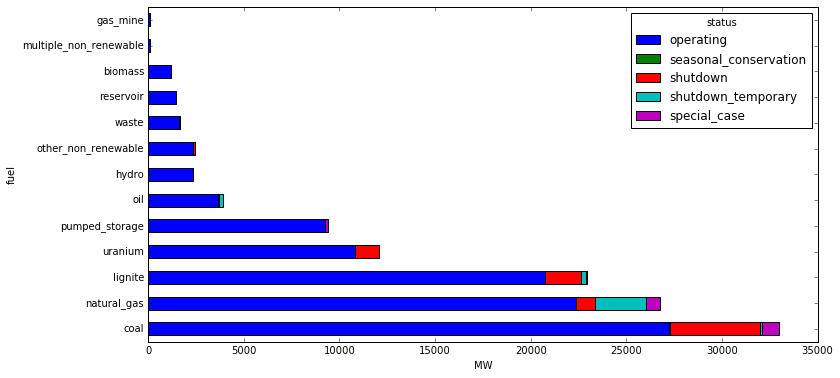

In [33]:
# FRAUKE: Ah, hier kommt matplotlib vor. Ginge das auch mit bokeh? Damit man mathplotlib
## gar nicht braucht?
# FRAUKE: Sehr nützlich und übersichtlich diese Grafik an dieser Stelle!
pivot_status_capacity = pd.pivot_table(
                        plantlist, 
                        values='capacity_net_bnetza',
                        columns='status',
                        index='fuel', 
                        aggfunc=np.sum
                        )
pivot_status_capacity.sort_values(by='operating', inplace=True, ascending=0)
pivot_status_capacity_plot=pivot_status_capacity.plot(kind='barh', 
                                                      stacked=True,
                                                      legend=True, 
                                                      figsize=(12, 6))
pivot_status_capacity_plot.set_xlabel("MW")
pivot_status_capacity_plot

### 9.1.2 Power plant age

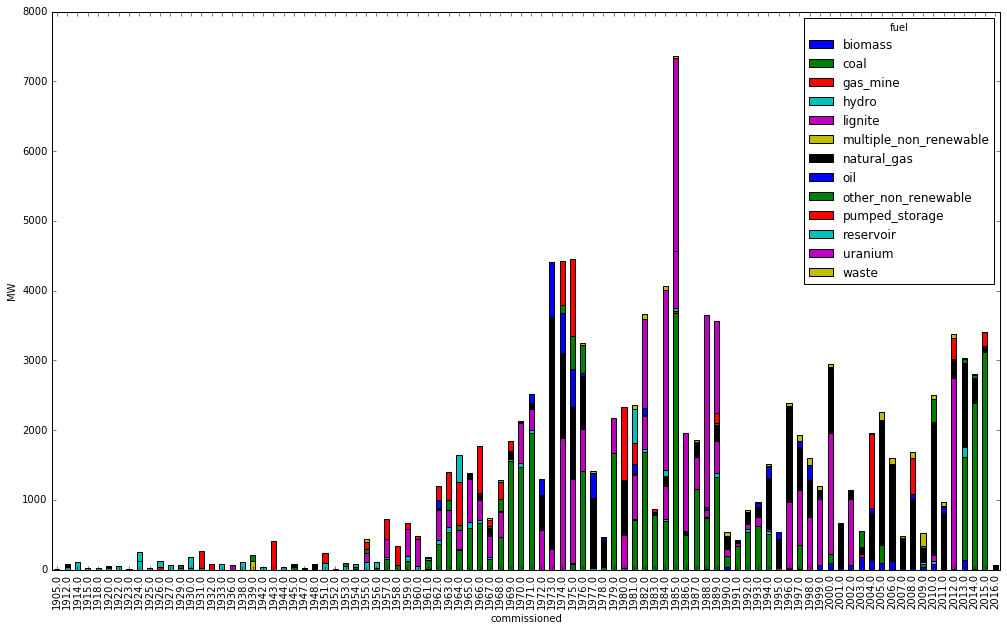

In [34]:
# FRAUKE: Auch spannend diese Grafik, nur leider nicht ganz so übersichtlich, da
## sich die Farben wiederholen beim fuel
## jedes Jahr einzeln aufgeführt ist
## Vorschlag: Commissioned in 5-Jahres Abschnitten darstellen
##            oder lieber die kumulierte Kapazität als Linie über die Jahre, eine Linie
##            pro Technologie und die Farben für fuel definieren damit die unterschiedlich
##            sind
plantlist_filtered = plantlist  #[plantlist.fuel=='coal']
pivot_age_capacity = pd.pivot_table(
                        plantlist_filtered, 
                        values='capacity_net_bnetza',
                        columns='fuel',
                        index='commissioned', 
#                        index='fuel',
#                        columns='commissioned',     
                        aggfunc=np.sum,
                        dropna=True
                        )
#pivot_age_capacity
pivot_age_capacity_plot=pivot_age_capacity.plot(kind='bar', 
                                                stacked=True,
                                                legend=True, 
                                                figsize=(17, 10))
pivot_age_capacity_plot.set_ylabel("MW")
pivot_age_capacity_plot

### 9.1.3 Block size vs year of commissioning

This chart is suitable to check outliers of commissioning years and block sizes. 
In theory, there should be no unexpected values, e.g. all commissioning years should be greater than 1900. 
Block sizes above 2000 MW are also unlikely.

In [35]:
## FRAUKE: Wieder das Farbenproblem, so weiß man nicht ob die großen Kraftwerke
## uranium oder multiple_non_renewable sind
plantlist_for_plot = plantlist.copy(deep=True)
plantlist_for_plot['capacity_float'] = pd.to_numeric(plantlist_for_plot['capacity_net_bnetza'], 
                                                     errors='coerce')
plantlist_for_plot['commissioned_float'] = pd.to_numeric(plantlist_for_plot['commissioned'], 
                                                         errors='coerce')
plot_blocksize_year = Scatter(plantlist_for_plot,  
                              x='commissioned_float', 
                              y='capacity_float',
                              color='fuel', 
                              title='Block-Size vs Year of Commissioning', 
                              xlabel='Year', 
                              ylabel='MW',
                              legend="top_left",
                              height=500,
                              width=700)
show(plot_blocksize_year)

## 9.2 Logical checks

### 9.2.1 Every power plant needs a capacity

List all entries with zero capacity.

In [36]:
# FRAUKE: cool! Keine Fehler dieser Art!
plantlist[plantlist.capacity_net_bnetza == 0]

,country_code,company,name_bnetza,block_bnetza,name_uba,postcode,city,street,state,commissioned_original,...,merge_comment,efficiency_data,efficiency_source,efficiency_estimate,network_node,voltage,network_operator,lat,lon,comment


### 9.2.2 Commissioning Dates

In [37]:
#Show all Plants with commisioning dates below 1900 
plantlist[plantlist['commissioned'] <= 1900]

,country_code,company,name_bnetza,block_bnetza,name_uba,postcode,city,street,state,commissioned_original,...,merge_comment,efficiency_data,efficiency_source,efficiency_estimate,network_node,voltage,network_operator,lat,lon,comment


In [38]:
# Show all Plants with invalid commisioning dates
plantlist[plantlist['commissioned'].isnull()]

,country_code,company,name_bnetza,block_bnetza,name_uba,postcode,city,street,state,commissioned_original,...,merge_comment,efficiency_data,efficiency_source,efficiency_estimate,network_node,voltage,network_operator,lat,lon,comment
BNA1337a,DE,DS Smith Paper Deutschland GmbH,Heizkraftwerk,Heizkraftwerk,NaN,63741,Aschaffenburg,Weichertstr. 7,Bayern,NaN,...,NaN,NaN,NaN,NaN,NaN,20,Aschaffenburger Versorgungs GmbH,49.988218,9.155761,NaN


### 9.2.3 Compare UBA and BNetzA data

#### 9.2.3.1 Postcodes of BNetzA and UBA lists should match

In [39]:
# FRAUKE: Gute Idee, wür cool wenn das funktioniert, da könnte man dann ein Marker in
## einer comment Spalte setzen
# List all entries with diverging postcodes (if a postcode is given)
# plantlist[(plantlist['uba_postcode'].notnull() == True) & (pd.to_numeric(plantlist.postcode, errors='coerce') != pd.to_numeric(plantlist.uba_postcode, errors='coerce'))]

#### 9.2.3.2 Compare Installed capacities

In [40]:
# FRAUKE: Auch das eine sehr interessante Info
#capacitycomparison = pd.DataFrame(plantlist.capacity / plantlist.capacity_uba)
#capacitycomparison['Name'] = plantlist.name
#capacitycomparison['Block'] = plantlist.block
#capacitycomparison['BnetzaCapacity'] = plantlist.capacity
#capacitycomparison['UBACapacity'] = plantlist.capacity_uba
#capacitycomparison.dropna(inplace=True)
#capacitycomparison.sort_values(by=0)

#### 9.2.3.3 Compare Comissioning Years

In [41]:
#commissioningcomparison = pd.DataFrame(plantlist.commissioned)
#commissioningcomparison['UBACommissioned'] = plantlist.uba_commissioned
#commissioningcomparison['commissioned_float'] = pd.to_numeric(commissioningcomparison['commissioned'],errors='coerce')
#commissioningcomparison['UBACommissioned_float'] = pd.to_numeric(commissioningcomparison['UBACommissioned'],errors='coerce')

#commissioningcomparison['Faktor'] = commissioningcomparison.commissioned_float - commissioningcomparison.UBACommissioned_float
#commissioningcomparison['Name'] = plantlist.name
#commissioningcomparison['Block'] = plantlist.block

#commissioningcomparison.dropna(subset = ['commissioned'], inplace=True)
#commissioningcomparison.dropna(subset = ['UBACommissioned'], inplace=True)
#commissioningcomparison = commissioningcomparison.sort_values(by='Faktor')

#commissioningcomparison

# 10. Documenting the data package (meta data)

We document the data packages meta data in the specific format JSON as proposed by the Open Knowledge Foundation. See the Frictionless Data project by OKFN (http://data.okfn.org/) and the Data Package specifications (http://dataprotocols.org/data-packages/) for more details.

In order to keep the notebook more readable, we first formulate the metadata in the human-readable YAML format using a multi-line string. We then parse the string into a Python dictionary and save that to disk as a JSON file.

In [42]:

# Here we define meta data of the resulting data package.
# The meta data follows the specification at:
# http://dataprotocols.org/data-packages/

metadata = """

name: opsd-power-plants-germany
title: List of thermal and hydro power plants in Germany
description: This dataset contains an augmented and corrected power plant list
    based on the power plant list provided by the BNetzA.
version: "2016-04-14"
keywords: [power plants, germany]
geographical-scope: Germany
opsd-changes-to-last-version: Fix errors, add column country_code

resources:
    - path: power_plants_germany.csv
      format: csv
      mediatype: text/csv
      schema:  # Schema according to: http://dataprotocols.org/json-table-schema/        
        fields:
            - name: id
              description: Power plant ID based on the ID provided in the
                  BNetzA-list.
              type: string
            - name: country_code
              description: Two-letter ISO code
              type: string  
            - name: company
              description: Company name
              type: string
            - name: name
              description: Power plant name
              type: string
              format: default
            - name: postcode
              description: Postcode
              type: string
              format: default
            - name: city
              description: City
              type: string
              format: default
            - name: street
              description: Street
              type: string
              format: default
            - name: state
              description: State
              type: string
              format: default
            - name: block
              description: Power plant block 
              type: string
              format: default
            - name: commissioned_original
              description: Year of commissioning (raw data)
              type: string
              format: default
            - name: commissioned
              description: Year of commissioning 
              type: integer
              format: default
            - name: retrofit
              description: Year of modernization according to UBA data
              type: integer
              format: default
            - name: shutdown
              description: Year of decommissioning
              type: integer
              format: default
            - name: status
              description: Power plant status
              type: string
              format: default
            - name: fuel
              description: Used fuel or energy source
              type: string
              format: default
            - name: technology
              description: Power plant technology or sort
              type: string
              format: default
            - name: type
              description: Purpose of the produced power
              type: string
              format: default
            - name: eeg
              description: Status of being entitled to a renumeration
              type: boolean
              format: default
            - name: chp
              description: Status of being able to supply heat
              type: boolean
              format: default
            - name: capacity
              description: Power capacity
              type: number
              format: default
            - name: capacity_uba
              description: Power capacity according to UBA data
              type: number
              format: default
            - name: chp_capacity_uba
              description: Heat capacity according to UBA data
              type: number
              format: default
            - name: merge_comment
              description: Comment on BNetzA - UBA merge
              type: string
              format: default              
            - name: efficiency_data
              description: Proportion between power output and input
              type: number
              format: default
            - name: efficiency_estimate
              description: Estimated proportion between power output and input
              type: number
              format: default
            - name: efficiency_source
              description: Source of efficiency data
              type: string
              format: default
            - name: network_node
              description: Connection point to the electricity grid 
              type: string
              format: default
            - name: voltage
              description: Grid or transformation level of the network node
              type: string
              format: default
            - name: network_operator
              description: Network operator of the grid or transformation level
              type: string
              format: default
            - name: name_uba
              description: Power plant name according to UBA data
              type: string
              format: default
            - name: lat
              description: Precise geographic coordinates - latitude
              type: number
              format: default
            - name: lon
              description: Precise geographic coordinates - longitude
              type: number
              format: default
            - name: comment
              description: Further comments
              type: string
              format: default
    - path: power_plants_germany.xlsx
      format: xlsx
      mediatype: application/vnd.openxmlformats-officedocument.spreadsheetml.sheet    

licenses:
    - type: MIT License
      url: http://www.opensource.org/licenses/MIT

sources:
    - name: BNetzA Kraftwerksliste,
      web: http://www.bundesnetzagentur.de/DE/Sachgebiete/ElektrizitaetundGas/Unternehmen_Institutionen/Versorgungssicherheit/Erzeugungskapazitaeten/Kraftwerksliste/kraftwerksliste-node.html
    - name: Umweltbundesamt Datenbank Kraftwerke in Deutschland,
      web: http://www.umweltbundesamt.de/dokument/datenbank-kraftwerke-in-deutschland

maintainers:
    - name: Clemens Gerbaulet
      email: cfg@wip.tu-berlin.de
      web: http://open-power-system-data.org/

views:
    # You can put hints here which kind of graphs or maps make sense to display your data. This makes the 
    # Data Package Viewer at http://data.okfn.org/tools/view automatically display visualazations of your data.
    # See http://data.okfn.org/doc/data-package#views for more details.    

# extend your datapackage.json with attributes that are not
# part of the data package spec
# you can add your own attributes to a datapackage.json, too

openpowersystemdata-enable-listing: True  # This is just an example we don't actually make use of yet.

opsd-jupyter-notebook-url: https://github.com/Open-Power-System-Data/datapackage_power_plants/blob/master/Power_Plants_DE.ipynb

"""

metadata = yaml.load(metadata)

datapackage_json = json.dumps(metadata, indent=4, separators=(',', ': '))

# 11. Write the results to file

Write the outputs

In [43]:
# FRAUKE: Hier heißt der Ordner powerplants_germany, auf github datapackage_power_plants
output_path = 'output/datapackage_powerplants_germany/'
# FRAUKE: Könnte der / nicht bei dem Dateinamen jeweils dazugeschrieben werden? Dann
# bräuchte man den output_path2 gar nicht
output_path2 = 'output/datapackage_powerplants_germany'

# Write the result to file
plantlist.to_csv(output_path + 'power_plants_germany.csv', encoding='utf-8')

# Write the results to excel file
plantlist.to_excel(output_path + 'power_plants_germany.xlsx', sheet_name='plants')

# Write the results to sqlite database
plantlist.to_sql(output_path + 'power_plants_germany',
                 sqlite3.connect(output_path + 'power_plants_germany.sqlite'),
                 if_exists="replace") 

# Write the information of the metadata
with open(os.path.join(output_path, 'datapackage.json'), 'w') as f:
    f.write(datapackage_json)

#JONATHAN: Das Folgende kann gelöscht werden, oder?    
#Set this string to this notebook's filename!    
nb_filename = 'download_and_process.ipynb'

# Save a copy of the notebook to markdown, to serve as the package README file
subprocess.call(['jupyter', 'nbconvert', '--to', 'markdown', nb_filename])
path_readme = os.path.join(output_path2, 'README.md')
try:
    os.remove(path_readme)
except Exception:
    pass
os.rename(nb_filename.replace('.ipynb', '.md'), path_readme)

# FRAUKE: Bei mir kommen hier mehrere Warnmeldungen, dass einige urls zu lang sind
## '255 characters since it exceeds Excel's limit for URLS'

C:\Users\Mario\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:829: UserWarning: Ignoring URL 'http://corporate.vattenfall.de/newsroom/pressemeldungen/pressemeldungen-import/janschwalde-verringert-seine-co2-bilanz-weiter/?_t_id=1B2M2Y8AsgTpgAmY7PhCfg%3d%3d&_t_q=wirkungsgrad&_t_tags=language%3ade%2csiteid%3a6137118f-e810-4130-802c-23139e8d9276&_t_ip=130.149.71.181&_t_hit.id=Kwd_Kestrel_Library_Epi_Types_Pages_PressReleasePageType/_5d05b802-9a68-425e-bbe1-eb0bc2631316_de&_t_hit.pos=4' with link or location/anchor > 255 characters since it exceeds Excel's limit for URLS
  force_unicode(url))
C:\Users\Mario\Anaconda3\lib\site-packages\xlsxwriter\worksheet.py:829: UserWarning: Ignoring URL 'http://corporate.vattenfall.de/uber-uns/geschaftsfelder/erzeugung/bauprojekte/Moorburg/Baustein_fuer_den_Klimaschutz/?_t_id=1B2M2Y8AsgTpgAmY7PhCfg%3d%3d&_t_q=wirkungsgrad&_t_tags=language%3ade%2csiteid%3a6137118f-e810-4130-802c-23139e8d9276&_t_ip=130.149.71.181&_t_hit.id=Kwd_Kestrel_Library_Epi_Types